The code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. 

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

# Imports & Setting up directories

In [ ]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    PATH = "./"  # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive

    drive.mount("/content/drive")

    %cd /content/drive/MyDrive/1_SP_Ham_func/simple_pendulum/

    %pip install torchdiffeq

    from src.dynamics import *
    from src.data import *
    from src.models_main import *
    from src.models_sub import *
    from src.plots import *
    from src.train import *
    from src.train_helpers import *
else:
    import sys

    sys.path.insert(0, "..")
    import os

    PATH = "./"


from src.dynamics import *
from src.data import *
from src.models_main import *
from src.models_sub import *
from src.plots import *
from src.train import *
from src.utils import *
from src.train_helpers import *

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint

# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json

In [ ]:
# auto reload the source files whenever they are changed
%load_ext autoreload
%autoreload 2

# Training

## Simple_HNN

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Simple_HNN_",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype=None,
    gtype=None,
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

In [ ]:
stats = model_training.train()

In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
u_func_none = U_FUNC(utype=None)

model_training.u_func = U_FUNC(utype=None)

model_training.time_steps = 200
model_training.num_trajectories = 20
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.u_func = u_func
model_training.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Input_HNN

### G is known

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Input_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

In [ ]:
stats = model_training.train()

In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.g_func = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

### G is known but no horizon

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[40, 40, 40, 40, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Input_HNN_chirp_nohorizon",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

In [ ]:
stats = model_training.train()

In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.g_func = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

### G is an NN

In [28]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=False,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Input_HNN_chirp_GNN",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created
Model initiatialized. 
 Number of parameters : 7562


In [29]:
stats = model_training.train()

horizon length : 20
[  0/ 10]	 train loss: 7.484456e+00, t_train: 0.28, test loss: 6.907747e+00, t_test: 0.10
[  1/ 10]	 train loss: 7.260284e+00, t_train: 0.20
horizon length : 25
[  2/ 10]	 train loss: 6.942301e+00, t_train: 0.28
[  3/ 10]	 train loss: 6.752009e+00, t_train: 0.32
horizon length : 30
[  4/ 10]	 train loss: 6.855915e+00, t_train: 0.39
[  5/ 10]	 train loss: 6.694682e+00, t_train: 0.36, test loss: 6.182197e+00, t_test: 0.15
horizon length : 35
[  6/ 10]	 train loss: 7.371741e+00, t_train: 0.43
[  7/ 10]	 train loss: 7.205282e+00, t_train: 0.44
horizon length : 40
[  8/ 10]	 train loss: 7.719395e+00, t_train: 0.49
[  9/ 10]	 train loss: 7.509027e+00, t_train: 0.48


In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.g_func = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

KeyboardInterrupt: 

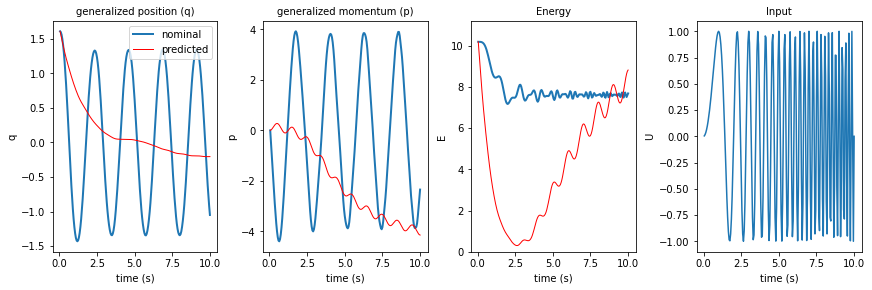

In [25]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Expanding_HNN

In [31]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=1,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Expanding_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created
mlp number of parameters : 1102
resblock number of parameters : 1079
Total number of H_net parameters : 7576
Model initiatialized. 
 Number of parameters : 1102


In [32]:
stats = model_training.train()

horizon length : 20
Model size increased
[  0/ 10]	 train loss: 9.390618e+00, t_train: 0.18, test loss: 5.548471e+00, t_test: 0.11
[  1/ 10]	 train loss: 9.327365e+00, t_train: 0.24
horizon length : 25
Model size increased
[  2/ 10]	 train loss: 9.122609e+00, t_train: 0.48
[  3/ 10]	 train loss: 9.053175e+00, t_train: 0.51
horizon length : 30
Model size increased
[  4/ 10]	 train loss: 9.011215e+00, t_train: 0.64
[  5/ 10]	 train loss: 8.931196e+00, t_train: 0.63, test loss: 5.945609e+00, t_test: 0.25
horizon length : 35
Model size increased
[  6/ 10]	 train loss: 9.392038e+00, t_train: 0.74
[  7/ 10]	 train loss: 9.293950e+00, t_train: 0.77
horizon length : 40
Model size increased
[  8/ 10]	 train loss: 9.836010e+00, t_train: 1.03
[  9/ 10]	 train loss: 9.715759e+00, t_train: 1.08


In [33]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [34]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.g_func = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Expanding_HNN_wide

In [35]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=1,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Expanding_wide_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created


NameError: name 'device' is not defined

In [ ]:
stats = model_training.train()

horizon length : 20
[  0/ 10]	 train loss: 7.484456e+00, t_train: 0.28, test loss: 6.907747e+00, t_test: 0.10
[  1/ 10]	 train loss: 7.260284e+00, t_train: 0.20
horizon length : 25
[  2/ 10]	 train loss: 6.942301e+00, t_train: 0.28
[  3/ 10]	 train loss: 6.752009e+00, t_train: 0.32
horizon length : 30
[  4/ 10]	 train loss: 6.855915e+00, t_train: 0.39
[  5/ 10]	 train loss: 6.694682e+00, t_train: 0.36, test loss: 6.182197e+00, t_test: 0.15
horizon length : 35
[  6/ 10]	 train loss: 7.371741e+00, t_train: 0.43
[  7/ 10]	 train loss: 7.205282e+00, t_train: 0.44
horizon length : 40
[  8/ 10]	 train loss: 7.719395e+00, t_train: 0.49
[  9/ 10]	 train loss: 7.509027e+00, t_train: 0.48


In [ ]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [ ]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.g_func = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Interp_HNN

In [44]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=2,
    horizon=False,
    horizon_type="auto",
    horizon_list=[40, 40, 40, 40, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Interp_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created
mlp number of parameters : 416
resblock number of parameters : 434
Total number of H_net parameters : 7794
Model initiatialized. 
 Number of parameters : 416


In [45]:
stats = model_training.train()

horizon length : 40
Model size increased
[  0/ 10]	 train loss: 6.530754e+00, t_train: 0.40, test loss: 8.455670e+00, t_test: 0.22
[  1/ 10]	 train loss: 6.467261e+00, t_train: 0.40
horizon length : 40
Model size increased
[  2/ 10]	 train loss: 6.336012e+00, t_train: 0.51
[  3/ 10]	 train loss: 6.276437e+00, t_train: 0.51
horizon length : 40
Model size increased
[  4/ 10]	 train loss: 6.185132e+00, t_train: 0.73
[  5/ 10]	 train loss: 6.128132e+00, t_train: 0.72, test loss: 7.993954e+00, t_test: 0.36
horizon length : 40
Model size increased
[  6/ 10]	 train loss: 6.057745e+00, t_train: 1.19
[  7/ 10]	 train loss: 6.002436e+00, t_train: 1.22
horizon length : 40
Model size increased
[  8/ 10]	 train loss: 5.920347e+00, t_train: 2.23
[  9/ 10]	 train loss: 5.867141e+00, t_train: 2.21


In [38]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [39]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.g_func = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

## Interp_horizon_HNN

In [40]:
set_all_seeds(manualSeed=123, new_results=False)

device = set_device()

model_training = Training(
    PATH,
    device,
    w=[1.0, 1.0],
    resnet_config=2,
    horizon=False,
    horizon_type="auto",
    horizon_list=[20, 25, 30, 35, 40],
    switch_steps=[100, 100, 100, 100, 100],
    epoch_num=None,
    loss_type="L2weighted",
    test_every=5,
    print_every=1,
    lr=1e-3,
    weight_decay=1e-4,
    model_name="Interp_horizon_HNN_chirp",
    time_steps=200,
    num_trajectories=125,
    batch_size=100,
    proportion=0.8,
    utype="chirp",
    gtype="simple",
    shuffle=False,
    coord_type="hamiltonian",
    save_suffix="",
)

Random Seed:  123
Available device: cpu
Number of training epochs:  10
Generating dataset
Dataset created
Paths created
mlp number of parameters : 416
resblock number of parameters : 434
Total number of H_net parameters : 7794
Model initiatialized. 
 Number of parameters : 416


In [41]:
stats = model_training.train()

horizon length : 20
Model size increased
[  0/ 10]	 train loss: 8.918359e+00, t_train: 0.21, test loss: 5.064832e+00, t_test: 0.11
[  1/ 10]	 train loss: 8.851995e+00, t_train: 0.23
horizon length : 25
Model size increased
[  2/ 10]	 train loss: 8.527746e+00, t_train: 0.43
[  3/ 10]	 train loss: 8.461437e+00, t_train: 0.43
horizon length : 30
Model size increased
[  4/ 10]	 train loss: 8.424047e+00, t_train: 0.63
[  5/ 10]	 train loss: 8.366490e+00, t_train: 0.60, test loss: 6.271338e+00, t_test: 0.28
horizon length : 35
Model size increased
[  6/ 10]	 train loss: 9.015510e+00, t_train: 1.19
[  7/ 10]	 train loss: 8.969194e+00, t_train: 1.16
horizon length : 40
Model size increased
[  8/ 10]	 train loss: 9.869020e+00, t_train: 2.30
[  9/ 10]	 train loss: 9.828007e+00, t_train: 2.28


In [42]:
# save training class that contains dataset and model
pickle_save(model_training, model_training.model_path + "model.pkl")

In [43]:
# load the model
model_training = pickle_load(model_training.model_path + "model.pkl")

#### plots

In [ ]:
loss_train = model_training.logs["train_loss"]
loss_test = model_training.logs["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    model_training.test_epochs,
    file_path=model_training.plot_path + "simple_pend_losses.png",
    horizons=None,
    horizon_steps=[200, 400, 550, 700, 850],
    title="train and test loss per epoch",
)

In [ ]:
train_horizon = model_training.horizon_list[-1]
print(train_horizon)

In [ ]:
title = ""
for n in [5, 10, 75]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "simple_pend_train" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
title = ""
for n in [5, 10, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=False,
        file_path=model_training.plot_path + "simple_pend_test" + str(n) + ".png",
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
set_all_seeds(manualSeed=123, new_results=False)

model_training.model.u_func = U_FUNC(utype=None)
model_training.model.g_func = G_FUNC(device, gtype=None)
model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0
model_training._init_data_loaders()

title = ""
for n in [0, 5, 15]:
    plot_results(
        model_training,
        n,
        train_horizon,
        train=True,
        file_path=model_training.plot_path + "noinput_simple_pend" + str(n) + ".png",
        show_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 1
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "1hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )

In [ ]:
utype = "sine"
u_func = U_FUNC(utype=utype)
u_func.params["T"] = 2.0
u_func.params["f0"] = 0
u_func.params["f1"] = 1
u_func.params["scale"] = 0.5
gtype = "simple"
g_func = G_FUNC(device, gtype=gtype)

model_training.model.u_func = u_func
model_training.model.g_func = g_func

model_training.time_steps = 200
model_training.num_trajectories = 25
model_training.batch_size = 100
model_training.proportion = 0.0

model_training._init_data_loaders()

title = ""
for n in [0, 10, 20]:
    plot_results(
        model_training,
        n,
        train_horizon,
        file_path=model_training.plot_path + "0.5hz_simple_pend" + str(n) + ".png",
        show_pred=False,
        only_pred=True,
        title=title,
        coord_type="hamiltonian",
    )